In [5]:
import sys, os
sys.path.append('../src')
sys.path.append('../models')


from architecture import modules

from data.config import X_chaos as X
from data.config import y_chaos as y

import numpy as np
import math
import itertools

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor

#from sklearn.metrics import mean_squared_error as mse
#from sklearn.metrics import mean_absolute_error as mae
#import sklearn.metrics as metrics
#from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import peak_signal_noise_ratio as psnr

#import cv2

In [23]:
def loadModel(model_archtitecture, folder='../../models/weights/', model_file='model', map_location=None, use_gpu=False):
    data_dir = os.path.abspath(folder) + '/'
    
    if map_location==None:
        if use_gpu:
            map_location = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            map_location = torch.device("cpu")
            
    model_archtitecture.load_state_dict(torch.load(data_dir + model_file, map_location=map_location), strict=False)
    return model_archtitecture

In [24]:
X.shape, y.shape
X_test = X[:,-222:]
y_test = y[:,-222:]
X_test.shape

(64, 222, 1, 120, 120)

In [47]:
# plot prediction

def plot_true_pred(model, n=16, max_depth=32, p=288, name='STLSTM_NT16', load_weights=True, savefig=True, savename='CLSTM'):
    
    fig, axs = plt.subplots(2, max_depth, sharex=True, sharey=True, figsize=(max_depth*2,4))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.xticks([]), plt.yticks([])

    cmap = 'viridis'
    #axs[0,0].imshow(y[0,p,0,:,:].astype(np.float64), cmap=cmap)
    axs[0,0].set_title(f'Depth: {0}')
    axs[0,0].set_ylabel(f'True')
    
    axs[1,0].set_ylabel(f'Predicted')

    #axs[1, 0].axis('off')
    for i in range(max_depth):
        y_true = y[0,p,i,:,:]
        axs[0,i].set_title(f'Depth: {i}')
        axs[0,i].imshow((y_true+127)/255., cmap=cmap)
    print(y_true)

    dt = 2
    
    time_length = len(X[::dt])
    time_span = n

    a = time_length//2# - time_span
    b = time_length//2 + time_span + 1

    _X = (X[::dt][a:b,p:p+1]+127)/255.
    print(_X)
    if load_weights:
        model.model = loadModel(model.model, model_file=name)
        
    with torch.no_grad():
        y_pred = model.predict(_X, max_depth=max_depth) # [depths,batch_size=1,features=1,:,:]

    #print(y_pred)
    for i in range(max_depth):
        _y_pred = y_pred[i,0,0,:,:]
        axs[1,i].imshow(_y_pred, cmap=cmap)
    axs[1,0].set_ylabel(f'Time span: {time_span+1}')

    if savefig:
        fig.savefig(savename, dpi=400, bbox_inches="tight")
    plt.title(f'Point {i}')
    plt.show()

[[  84   81   80 ... -126 -126 -126]
 [  81   77   77 ... -126 -126 -126]
 [  75   72   71 ... -126 -126 -126]
 ...
 [-126 -126 -126 ...  -30 -114 -115]
 [-126 -126 -126 ...  -57 -119 -119]
 [-126 -126 -126 ...  -61 -119 -120]]
[[[[[ 0.07058824  0.0745098   0.1372549  ...  0.00392157  0.00392157
      0.00392157]
    [ 0.0745098   0.08627451  0.15294118 ...  0.00392157  0.00392157
      0.00392157]
    [ 0.09803922  0.10588235  0.20784314 ...  0.00392157  0.00392157
      0.00392157]
    ...
    [ 0.00392157  0.00392157  0.00392157 ...  0.31372549  0.03921569
      0.03529412]
    [ 0.00392157  0.00392157  0.00392157 ...  0.23529412  0.02745098
      0.02745098]
    [ 0.00392157  0.00392157  0.00392157 ...  0.21960784  0.02745098
      0.02352941]]]]



 [[[[ 0.10196078  0.11372549  0.21960784 ...  0.00392157  0.00392157
      0.00392157]
    [ 0.11372549  0.12941176  0.24313725 ...  0.00392157  0.00392157
      0.00392157]
    [ 0.14509804  0.16470588  0.3254902  ...  0.00392157  0.00

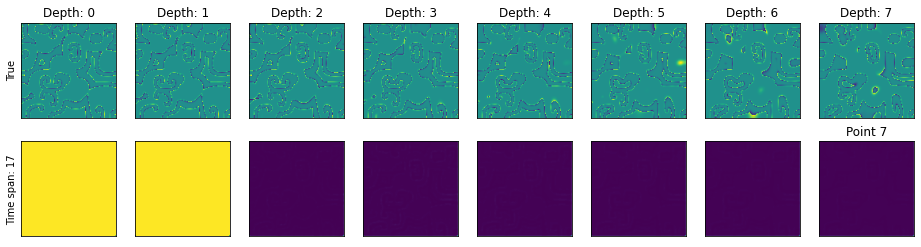

In [48]:
p = 100
plot_true_pred(modules.Model(modules.STLSTM(1,64, directional=1)), n=16, max_depth=8, p=p, name='STLSTM_NT16_chaos', savename=f'STLSTM_NT16_p{p}')


In [ ]:
# mse per layer

def get_loss_per_depth(model, criterion=mse, time_steps=16, max_depth=32, num_examples=None, name='CLSTM_NT16', load_weights=True):
    time_length = len(X)

    if load_weights:
        model.model = loadModel(model.model, model_file=name)

        
    a = time_length//2 - time_steps
    b = time_length//2 + time_steps + 1

    #if num_examples==None:
    batch_inds = np.random.choice(list(range(len(X_test[0,:]))),
                                  size=(len(X_test[0,:])//16,16),replace=False)
    y_preds, y_test_trues = [], []
    for inds in batch_inds:
        y_pred = model.predict(X_test[a:b,inds], max_depth=max_depth)
        y_test_true = np.swapaxes(y_test[:,inds], 0,2)

        y_preds.append(y_pred)
        y_test_trues.append(y_test_true)
      
    y_preds = np.concatenate(y_preds, 1)
    y_test_trues = np.concatenate(y_test_trues, 1)
    #print(y_preds.shape, y_test_trues.shape)
    #(32, 288, 1, 120, 120) (32, 288, 1, 120, 120)
    
    losses = []
    for i in range(max_depth): 
        if num_examples==None:
            losses.append(criterion(y_test_trues[i], y_preds[i]))
        else:
            inds = np.random.choice(list(range(len(y_preds[0,:]))), size=num_examples, replace=False)
            losses.append(criterion(y_test_trues[i, inds], y_preds[i, inds]))
    return losses
    #print(mses[-1])

In [7]:
def ssim_b(img1, img2):
    img1 = np.swapaxes(img1, -3,-1)
    img2 = np.swapaxes(img2, -3,-1)
    ds = len(np.shape(img1))
    #print(img1.shape)
    if ds > 4:
        keep_shape = [img1.shape[i-1] for i in np.flip(range(ds, ds-3,-1))]
        return ssim(img1.reshape((-1, *keep_shape)), img2.reshape((-1, *keep_shape)), multichannel=True)
    else:
        return ssim(img1, img2, multichannel=True)
    
def psnr_b(img1, img2):
    img1 = np.swapaxes(img1, -3,-1)
    img2 = np.swapaxes(img2, -3,-1)
    ds = len(np.shape(img1))
    #print(img1.shape)
    if ds > 4:
        keep_shape = [img1.shape[i-1] for i in np.flip(range(ds, ds-3,-1))]
        return ssim(img1.reshape((-1, *keep_shape)), img2.reshape((-1, *keep_shape)))
    else:
        return psnr(img1, img2)
    
def rmse_b(img1, img2):
    return mse(img1.reshape((-1,)), img2.reshape((-1,)), squared=False)
    
def mae_b(img1, img2):
    return mae(img1.reshape((-1,)), img2.reshape((-1,)))

def psnr_b(img1, img2):
    img1 = np.swapaxes(img1, -3,-1)
    img2 = np.swapaxes(img2, -3,-1)
    ds = len(np.shape(img1))
    #print(img1.shape)
    if ds > 4:
        keep_shape = [img1.shape[i-1] for i in np.flip(range(ds, ds-3,-1))]
        return ssim(img1.reshape((-1, *keep_shape)), img2.reshape((-1, *keep_shape)))

def emd(img1, img2):
    # convert to (?,h*w)
    # get only subsample if image is too big:
    h, w = img1.shape[-2:]
    max_x_off, max_y_off = max(0,w - 60), max(0,h - 60)   
    sigs = []
    s=[60,60]
    _s = np.shape(img1)[:-2]
    for _s_ in _s:
        s.append(_s_)
    #print(list(s))
    img1 = np.swapaxes(np.swapaxes(img1, 0,-2), 1,-1)
    img2 = np.swapaxes(np.swapaxes(img2, 0,-2), 1,-1)
    
    new_img1, new_img2 = np.zeros(s), np.zeros(s)
    for i in range(len(new_img1[0,0,:])):
        x_start, y_start = np.random.randint(0,max_x_off), np.random.randint(0,max_y_off)
        x_end, y_end = min(x_start+60, w), min(y_start+60, h)
        #np.swapaxes(img1, 0,-1)
        new_img1[:,:,i] = img1[y_start:y_end, x_start:x_end,i]
        new_img2[:,:,i] = img2[y_start:y_end, x_start:x_end,i]

    new_img1 = np.swapaxes(new_img1, 0,-1)
    new_img2 = np.swapaxes(new_img2, 0,-1)
    #print('hi',new_img1.shape,new_img2.shape)
        
    for img in [new_img1, new_img2]:
        h, w = img.shape[-2:]
        #print(h, w)
        
        ds = len(np.shape(img))
        if ds > 2:
            keep_shape = [img.shape[i] for i in np.flip(range(ds, ds-2,-1))-1]
            img = img.reshape(-1, *keep_shape).reshape(-1,h*w)  
            
        sig = np.empty((len(img), h*w, 3))
        #print(sig.shape)
        inds = np.array(list(itertools.product(np.arange(0,h,1), np.arange(0,w,1)))).T

        for n in range(len(img)):
            #print('HO',img[n].shape)
            sig[n] = np.array([img[n], inds[0], inds[1]]).T
        sigs.append(cv2.normalize(sig, None, 1, 0, cv2.NORM_MINMAX, cv2.CV_32FC1))
        
    dists = []
    for i in range(len(sigs[0])):
        dist, _, _= cv2.EMD(sigs[0][i], sigs[1][i], 2)
        dists.append(dist)
        #print(dist)
    print(np.mean(dists))
    return np.mean(dists)

In [17]:
Avg16_rmse = get_loss_per_depth(modules.Model(modules.AlwaysAverage()), 
                           criterion=rmse_b, load_weights=False)
CLSTM16_rmse = get_loss_per_depth(modules.Model(modules.CLSTM(1,32, directional=2)), 
                         criterion=rmse_b, name='CLSTM_NT16')
STLSTM16_rmse = get_loss_per_depth(modules.Model(modules.STLSTM(1,32, directional=2)), 
                         criterion=rmse_b, name='STLSTM_NT16')

In [9]:
CLSTM16_ssim = get_loss_per_depth(modules.Model(modules.CLSTM(1,32, directional=2)), 
                         criterion=ssim_b, name='CLSTM_NT16')
STLSTM16_ssim = get_loss_per_depth(modules.Model(modules.STLSTM(1,32, directional=2)), 
                         criterion=ssim_b, name='STLSTM_NT16')
Avg16_ssim = get_loss_per_depth(modules.Model(modules.AlwaysAverage()), 
                           criterion=ssim_b, load_weights=False)

/home/roland/anaconda3/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [10]:
CLSTM16_psnr = get_loss_per_depth(modules.Model(modules.CLSTM(1,32, directional=2)), 
                         criterion=psnr_b, name='CLSTM_NT16')
STLSTM16_psnr = get_loss_per_depth(modules.Model(modules.STLSTM(1,32, directional=2)), 
                         criterion=psnr_b, name='STLSTM_NT16')
Avg16_psnr = get_loss_per_depth(modules.Model(modules.AlwaysAverage()), 
                           criterion=psnr_b, load_weights=False)

In [116]:
CLSTM16_emd = get_loss_per_depth(modules.Model(modules.CLSTM(1,32, directional=2)), 
                         criterion=emd, name='CLSTM_NT16', num_examples=20, max_depth=32)
#STLSTM16_emd = get_loss_per_depth(modules.Model(modules.STLSTM(1,22, directional=2)), 
#                         criterion=emd, name='STLSTM_NT16', num_examples=20, max_depth=6)
#Avg16_emd = get_loss_per_depth(modules.Model(modules.AlwaysAverage()), 
#                           criterion=emd, load_weights=False, num_examples=2, max_depth=6)

0.0029224974665946015
0.0030857568276890864
0.005132024104629333
0.003697197901783511
0.005344942312998076
0.008993077867974838
0.009398477346015474
0.01131697241216898
0.01182840116477261
0.015994437613214056
0.020640721971479554
0.022269034199416636
0.029209706280380488
0.030149628858392438
0.02665441264398396
0.027630192507058383
0.03421108933786551
0.03233464950074752
0.02796173132956028
0.0334919065857927
0.032842650761206946
0.03866892553245028
0.040620698531468706
0.04258530295143525
0.03538368920174738
0.037065603366742535
0.035277029623587926
0.03576541809986035
0.0401642460996906
0.04006992879634102
0.04730110932141542
0.05482527144874136


In [11]:
#MIM16_mae = get_loss_per_depth(modules.Model(modules.MIM(1,32, directional=2)), 
#                         criterion=mae_b, name='MIM_NT16')
CLSTM16_mae = get_loss_per_depth(modules.Model(modules.CLSTM(1,32, directional=2)), 
                         criterion=mae_b, name='CLSTM_NT16')
STLSTM16_mae = get_loss_per_depth(modules.Model(modules.STLSTM(1,32, directional=2)), 
                         criterion=mae_b, name='STLSTM_NT16')
Avg16_mae = get_loss_per_depth(modules.Model(modules.AlwaysAverage()), 
                           criterion=mae_b, load_weights=False)

In [ ]:
STLSTM16_emd = get_loss_per_depth(modules.Model(modules.STLSTM(1,22, directional=2)), 
                         criterion=emd, name='STLSTM_NT16', num_examples=64, max_depth=32)

0.0003003463828160117


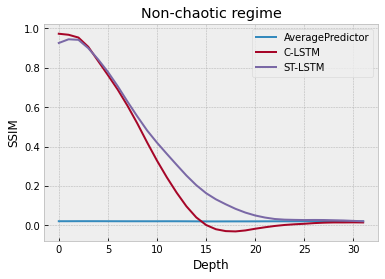

In [12]:
plt.style.use('bmh')
s = [0,32]
plt.plot(range(s[0],s[1]), Avg16_ssim[s[0]:s[1]], label='AveragePredictor')
plt.plot(range(s[0],s[1]),CLSTM16_ssim[s[0]:s[1]], label='C-LSTM')
plt.plot(range(s[0],s[1]), STLSTM16_ssim[s[0]:s[1]], label='ST-LSTM')
plt.legend()
plt.title('Non-chaotic regime')
plt.xlabel('Depth')
plt.ylabel('SSIM')
plt.savefig('SSIM', dpi=400, bbox_inches="tight" )

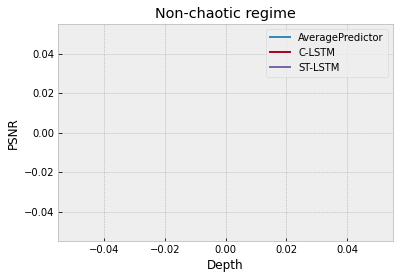

In [13]:
plt.style.use('bmh')
s = [0,32]
plt.plot(range(s[0],s[1]), Avg16_psnr[s[0]:s[1]], label='AveragePredictor')
plt.plot(range(s[0],s[1]),CLSTM16_psnr[s[0]:s[1]], label='C-LSTM')
plt.plot(range(s[0],s[1]), STLSTM16_psnr[s[0]:s[1]], label='ST-LSTM')
plt.legend()
plt.title('Non-chaotic regime')

plt.xlabel('Depth')
plt.ylabel('PSNR')
plt.savefig('PSNR', dpi=400, bbox_inches="tight" )

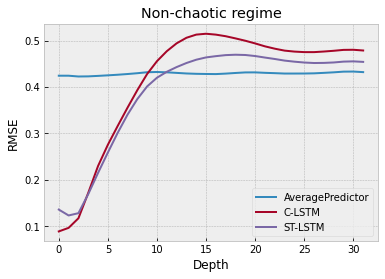

In [18]:
plt.style.use('bmh')
s = [0,32]
plt.plot(range(s[0],s[1]), Avg16_rmse[s[0]:s[1]], label='AveragePredictor')
plt.plot(range(s[0],s[1]),CLSTM16_rmse[s[0]:s[1]], label='C-LSTM')
plt.plot(range(s[0],s[1]), STLSTM16_rmse[s[0]:s[1]], label='ST-LSTM')
plt.legend()
plt.title('Non-chaotic regime')
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.savefig('RMSE', dpi=400, bbox_inches="tight" )

ValueError: x and y must have same first dimension, but have shapes (32,) and (6,)

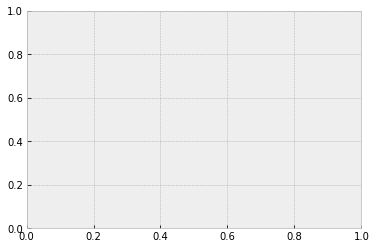

In [123]:
plt.style.use('bmh')
s = [0,32]
plt.plot(range(s[0],s[1]), Avg16_emd[s[0]:s[1]], label='AveragePredictor')
plt.plot(range(s[0],s[1]),CLSTM16_emd[s[0]:s[1]], label='C-LSTM')
plt.plot(range(s[0],s[1]), STLSTM16_emd[s[0]:s[1]], label='ST-LSTM')
plt.legend()
plt.title('Non-chaotic regime')
plt.xlabel('Depth')
plt.ylabel('EMD')
plt.savefig('EMD', dpi=400, bbox_inches="tight" )

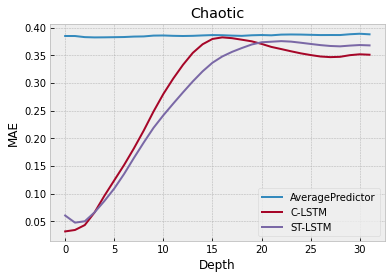

In [19]:
plt.style.use('bmh')
s = [0,32]
plt.plot(range(s[0],s[1]), Avg16_mae[s[0]:s[1]], label='AveragePredictor')
plt.plot(range(s[0],s[1]),CLSTM16_mae[s[0]:s[1]], label='C-LSTM')
plt.plot(range(s[0],s[1]), STLSTM16_mae[s[0]:s[1]], label='ST-LSTM')
#plt.plot(range(s[0],s[1]),MIM16_mae[s[0]:s[1]], label='MIM-LSTM')
plt.legend()
plt.title('Chaotic')
plt.xlabel('Depth')
plt.ylabel('MAE')
plt.savefig('MAE', dpi=400, bbox_inches="tight" )

In [48]:
ssim_b(np.zeros((120,120,3)), np.zeros((120,120,3)))

1.0

In [8]:
def plot_true_pred(model, n=16, max_depth=32, p=288, name='CLSTM_NT16', load_weights=True, savefig=True, savename='CLSTM'):
    
    fig, axs = plt.subplots(2, max_depth, sharex=True, sharey=True, figsize=(max_depth*2,4))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.xticks([]), plt.yticks([])

    cmap = 'viridis'
    #axs[0,0].imshow(y[0,p,0,:,:].astype(np.float64), cmap=cmap)
    axs[0,0].set_title(f'Depth: {0}')
    axs[0,0].set_ylabel(f'True')
    
    axs[1,0].set_ylabel(f'Predicted')

    #axs[1, 0].axis('off')
    for i in range(max_depth):
        y_true = y[0,p,i,:,:]
        axs[0,i].set_title(f'Depth: {i}')
        axs[0,i].imshow(y_true.astype(np.float64), cmap=cmap)

    time_length = len(X)
    time_span = n

        
    a = time_length//2 - time_span
    b = time_length//2 + time_span + 1

    _X = X[a:b,p:p+1]
    
    if load_weights:
        model.model = loadModel(model.model, model_file=name)
        
    with torch.no_grad():
        y_pred = model.predict(_X, max_depth=max_depth) # [depths,batch_size=1,features=1,:,:]

    for i in range(max_depth):
        _y_pred = y_pred[i,0,0,:,:]
        axs[1,i].imshow(_y_pred.astype(np.float64), cmap=cmap)
    axs[1,0].set_ylabel(f'Time span: {time_span+1}')

    if savefig:
        fig.savefig(savename, dpi=400, bbox_inches="tight")
    plt.title(f'Point {i}')
    plt.show()

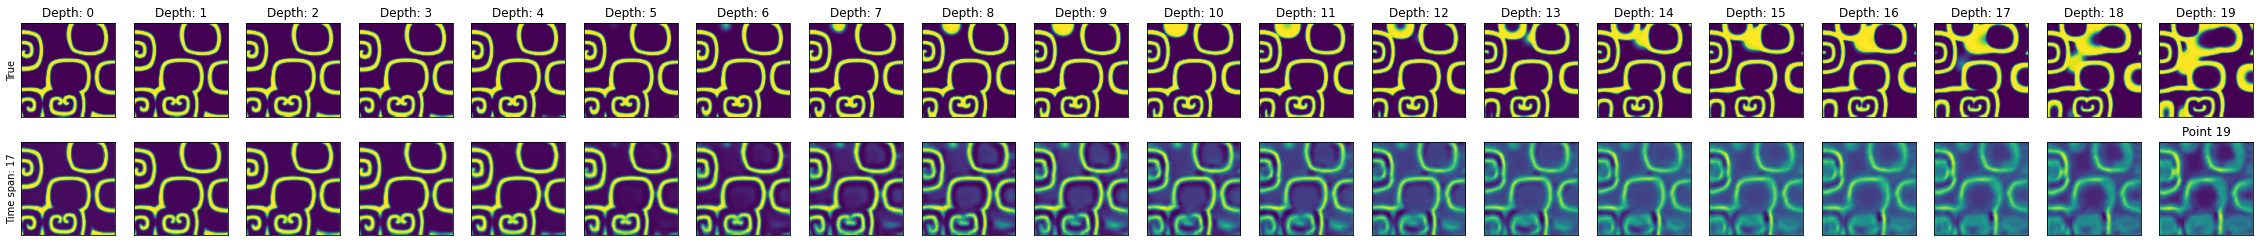

In [14]:
p = 890
plot_true_pred(modules.Model(modules.CLSTM(1,32, directional=2)), n=16, max_depth=20, p=p, name='CLSTM_NT16_chaos', savename=f'CLSTM_NT16_p{p}')
#plot_true_pred(modules.Model(modules.STLSTM(1,22, directional=2)), n=16, max_depth=20, p=p, name='STLSTM_NT16', savename=f'STLSTM_NT16_p{p}')

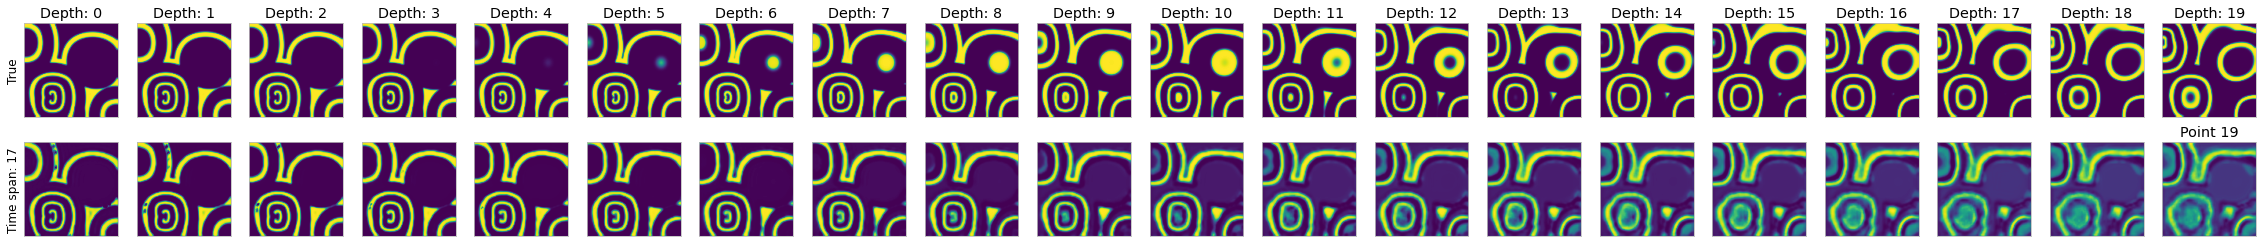

In [18]:
plot_true_pred(modules.Model(modules.STLSTM(1,32, directional=2)), n=16, max_depth=20, p=p, name='STLSTM_NT16', savename=f'STLSTM_NT16_p{p}')

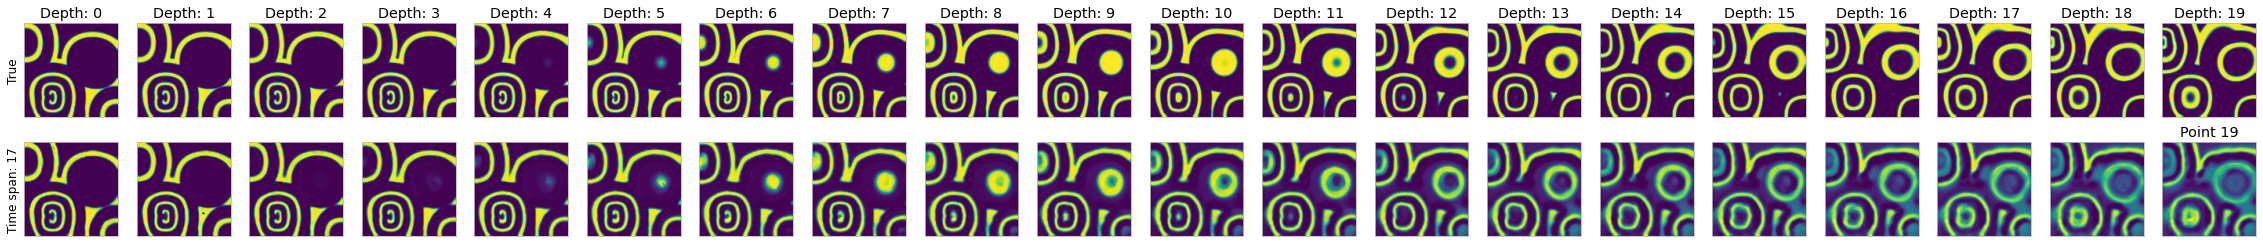

In [15]:
plot_true_pred(modules.Model(modules.CLSTM(1,32, directional=2)), n=16, max_depth=20, p=p, name='CLSTM_NT16', savename=f'MIM_NT16_p{p}')

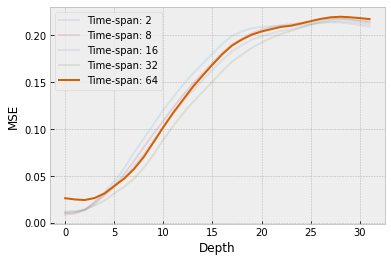

In [44]:
plt.style.use('bmh')

a=0.12
plt.plot(range(32),m2, label='Time-span: 2', alpha=a)
#plt.plot(range(32), m4, label='Time-span: 4')
plt.plot(range(32), m8, label='Time-span: 8', alpha=a)
plt.plot(range(32), m16, label='Time-span: 16', alpha=a)
plt.plot(range(32), m32, label='Time-span: 32', alpha=a)
plt.plot(range(32), m64, label='Time-span: 64')


plt.legend()

plt.xlabel('Depth')
plt.ylabel('MSE')

plt.savefig('depth_vs_mse_64', dpi=400, bbox_inches="tight" )

#plt.xlim([0,10])
#plt.ylim([0,0.02])
#plt.title('Same model, trained with different input time-spans around the target time to be predicted')

In [9]:
n1 = getMSE_per_depth(n=16, dt=1)
n2 = getMSE_per_depth(n=16, dt=2)
#m8 = getMSE_per_depth(n=8)
#m16 = getMSE_per_depth(n=16)
#m32 = getMSE_per_depth(n=32)
#m64 = getMSE_per_depth(n=64)

In [35]:
ssim(np.zeros((120,120,1)), np.zeros((120,120,1)), multichannel=True)

ssim_b = lambda img1, img2: ssim(img1, img2, multichannel=True)
ssim_b(np.zeros((120,120,1)), np.zeros((120,120,1)))

1.0

In [38]:
m2

[0.001974513,
 0.002011216,
 0.0029983143,
 0.006260196,
 0.011422554,
 0.017950468,
 0.02735424,
 0.038243525,
 0.04931633,
 0.059921682,
 0.07009728,
 0.079262845,
 0.08732353,
 0.094628274,
 0.10097647,
 0.10699361,
 0.11318802,
 0.11818407,
 0.12170823,
 0.12426648,
 0.12628178,
 0.12814282,
 0.12975356,
 0.13096312,
 0.13273904,
 0.13466734,
 0.13640492,
 0.13747865,
 0.13804139,
 0.1379509,
 0.13769765,
 0.13773616]

In [39]:
m8

[0.001680249,
 0.0018544125,
 0.0028196925,
 0.0061751655,
 0.011799356,
 0.018825574,
 0.027681256,
 0.038019784,
 0.049272288,
 0.05972977,
 0.069611765,
 0.0784861,
 0.08646846,
 0.09371908,
 0.09971439,
 0.10513356,
 0.11080436,
 0.11568116,
 0.119459674,
 0.12258228,
 0.12510897,
 0.12759009,
 0.1297824,
 0.13147824,
 0.13364883,
 0.13581558,
 0.13764559,
 0.13878928,
 0.1394855,
 0.1395052,
 0.13928322,
 0.13921611]

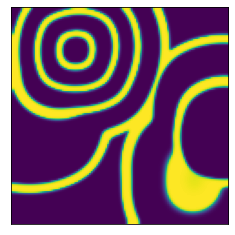

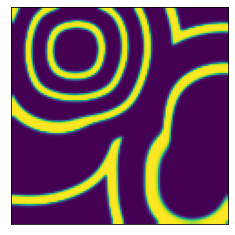

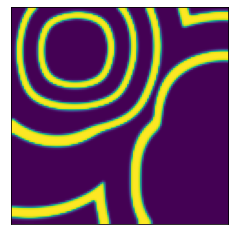

(None, None)

In [10]:
#plot time series

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.xticks([]), plt.yticks([])

p = 100
plt.imshow(X_test[0,p,0,:,:].astype(np.float64)), plt.xticks([]), plt.yticks([])
plt.savefig('p200_t0', dpi=400, bbox_inches="tight"),plt.show()

plt.imshow(X_test[64,p,0,:,:].astype(np.float64)), plt.xticks([]), plt.yticks([])
plt.savefig('p200_t40', dpi=400, bbox_inches="tight"),plt.show()

plt.imshow(X_test[127,p,0,:,:].astype(np.float64)), plt.xticks([]), plt.yticks([])
plt.savefig('p200_t127', dpi=400, bbox_inches="tight"),plt.show()


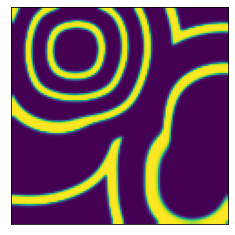

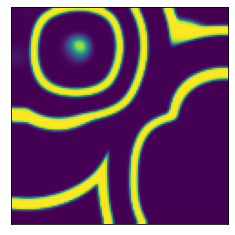

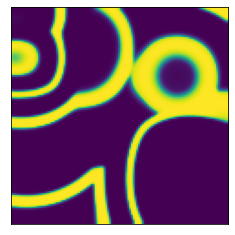

(None, None)

In [15]:
#plot layer series

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.xticks([]), plt.yticks([])

p = 100
plt.imshow(y_test[0,p,0,:,:].astype(np.float64)), plt.xticks([]), plt.yticks([])
plt.savefig('p200_d0', dpi=400, bbox_inches="tight"),plt.show()

plt.imshow(y_test[0,p,16,:,:].astype(np.float64)), plt.xticks([]), plt.yticks([])
plt.savefig('p200_d16', dpi=400, bbox_inches="tight"),plt.show()

plt.imshow(y_test[0,p,31,:,:].astype(np.float64)), plt.xticks([]), plt.yticks([])
plt.savefig('p200_d31', dpi=400, bbox_inches="tight"),plt.show()

In [8]:
#X0 = torch.tensor(X_test, device=model.device).float()[:32,:2]
X0.shape
#X0.max(), X0.min()

torch.Size([32, 2, 1, 120, 120])

In [7]:
model.model

CLSTM_bottleneck(
  (encoder): TimeDistributed(
    (module): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Sigmoid()
    )
  )
  (encoder_clstm_fwd): CLSTMLayer(
    (cell): CLSTMCell(
      (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (encoder_clstm_bwd): CLSTMLayer(
    (cell): CLSTMCell(
      (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (decoder_clstm): CLSTMCell(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): TimeDistributed(
    (module): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [11]:
#X1 = model.model.encoder(X0)
X2_fwd = model.model.encoder_clstm_fwd(X1)
X2_bwd = model.model.encoder_clstm_bwd(X1)

In [15]:
model.model.decoder_clstm(X2_fwd[0], X2_fwd[1])

RuntimeError: input has inconsistent input_size: got 2, expected 32

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [23]:
_X=torch.cat((torch.from_numpy(X[0,0]),torch.from_numpy(X[0,0]),torch.from_numpy(X[0,0])), dim=0)

In [13]:
_X = torch.from_numpy(X_test)
_X.to()

torch.Size([128, 288, 1, 120, 120])

In [14]:
_X1 = model.model.encoder(_X)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _thnn_conv2d_forward